## Imports for Data Extraction and Preprocessing

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import ijson
import logging
import numpy as np
import seaborn as sns

In [24]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Parse Data and create DataFrame

In [25]:
def parse_json(file_path, num_events):
    """
    parses the json file and returns a list of events

    :param file_path: path to the json file
    :param num_events: number of events that should be parsed
    """
    with open(file_path, 'rb') as f:
        events = ijson.items(f, 'item')
        limited_events = [next(events) for _ in range(num_events)]
        logger.info('All events parsed. Total number of events: {}'.format(len(limited_events)))
        return limited_events

# specify the number of events that should be preprocessed, max number of events is 264395
num_events = 264395
events = parse_json('stuttgart_events.json', num_events)

# Handle the nested structure of the original json file
events_df = pd.DataFrame(events)
all_keys = set().union(*events_df["eventData"].apply(lambda x: x.keys()))
for key in all_keys:
    events_df[key] = events_df["eventData"].apply(lambda x: x.get(key, None))

keys_location = set().union(*events_df["location"].apply(lambda x: x.keys()))
for key in keys_location:
    events_df[f'location.{key}'] = events_df["location"].apply(lambda x: x.get(key, None))

keys_location_location = set().union(*events_df["location.location"].apply(lambda x: x.keys()))
for key in keys_location_location:
    events_df[f'location.location.{key}'] = events_df["location.location"].apply(lambda x: x.get(key, None))

keys_location_location_address = set().union(*events_df["location.location.address"].apply(lambda x: x.keys()))
for key in keys_location_location_address:
    events_df[f'location.location.address.{key}'] = events_df["location.location.address"].apply(lambda x: x.get(key, None))

## Data Cleaning

In [ ]:
# delete dictionary columns
events_df = events_df.drop('eventData', axis=1)
events_df = events_df.drop('location', axis=1)
events_df = events_df.drop('location.location', axis=1)
events_df = events_df.drop('location.location.address', axis=1)

In [ ]:
# Only keep events that were not cancelled
events_df = events_df[events_df['cancelled'] == False]
print(events_df.shape)

(261664, 60)


In [ ]:
# Only keep events where the location is actually in Stuttgart
events_df = events_df[events_df['location.location.address.city'] == 'Stuttgart']
print(events_df.shape)

(261664, 60)


## Visualize missing values

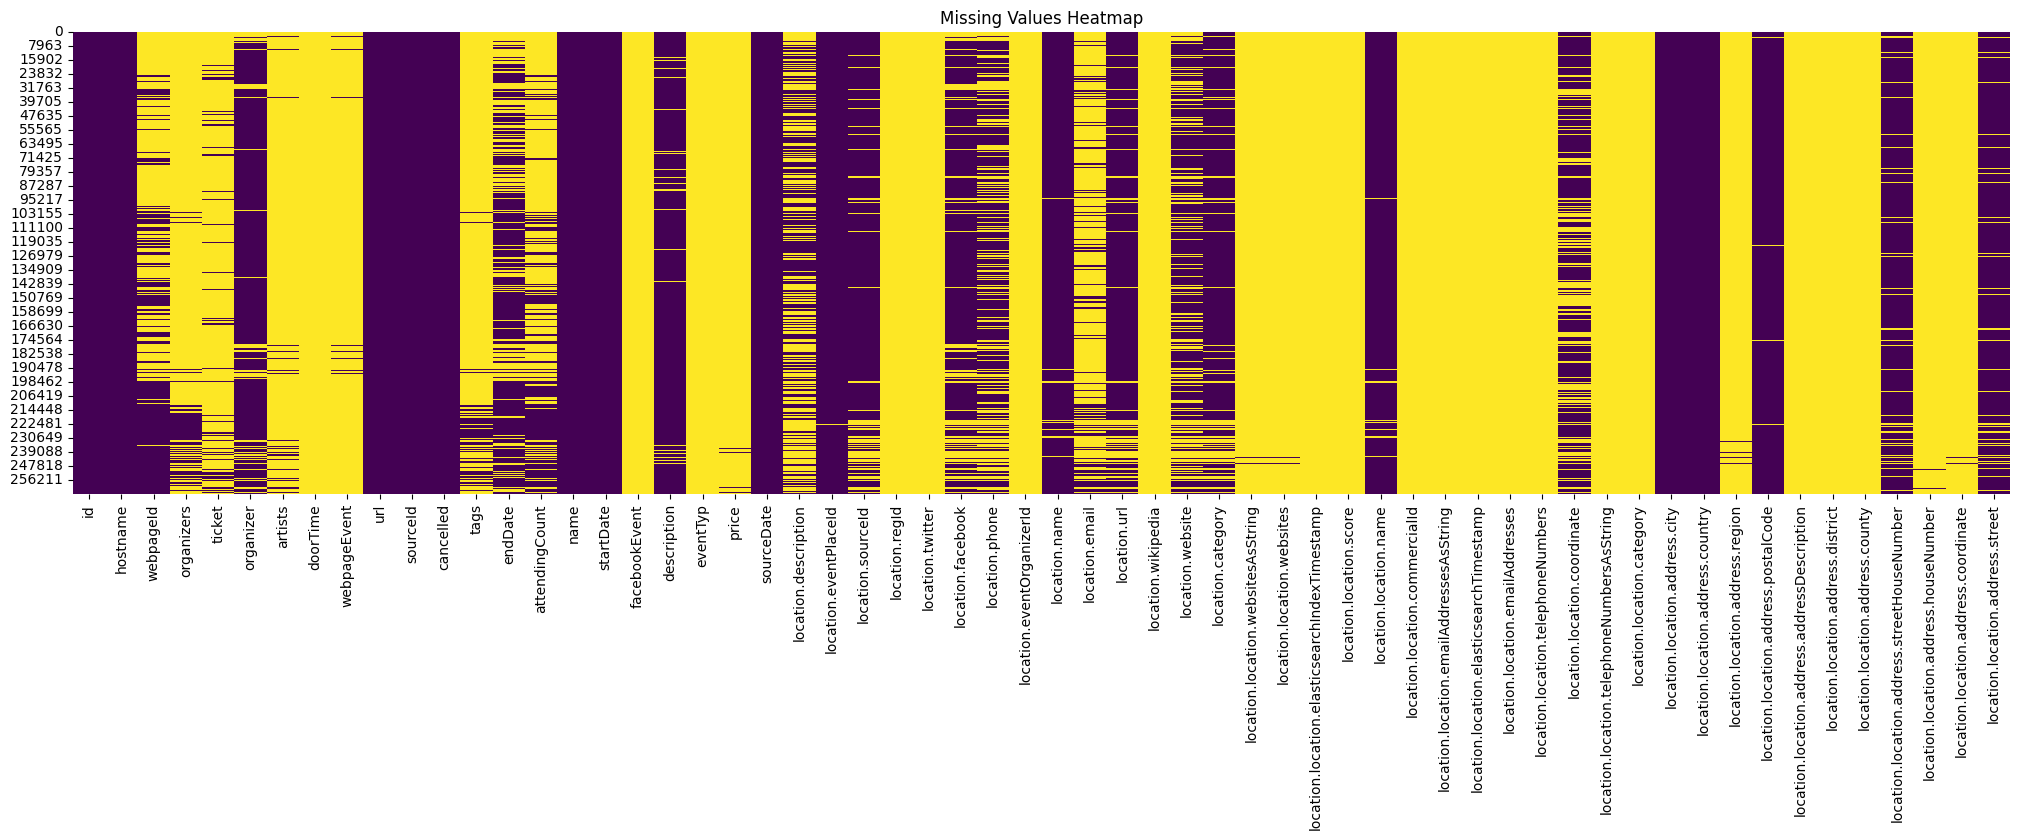

In [ ]:
#Create a heatmap of missing values
plt.figure(figsize=(25, 6))  # Adjust the figure size as needed
sns.heatmap(events_df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

INFO:root:Shape of the DataFrame after dropping columns with more than 80% missing values: (261664, 30)


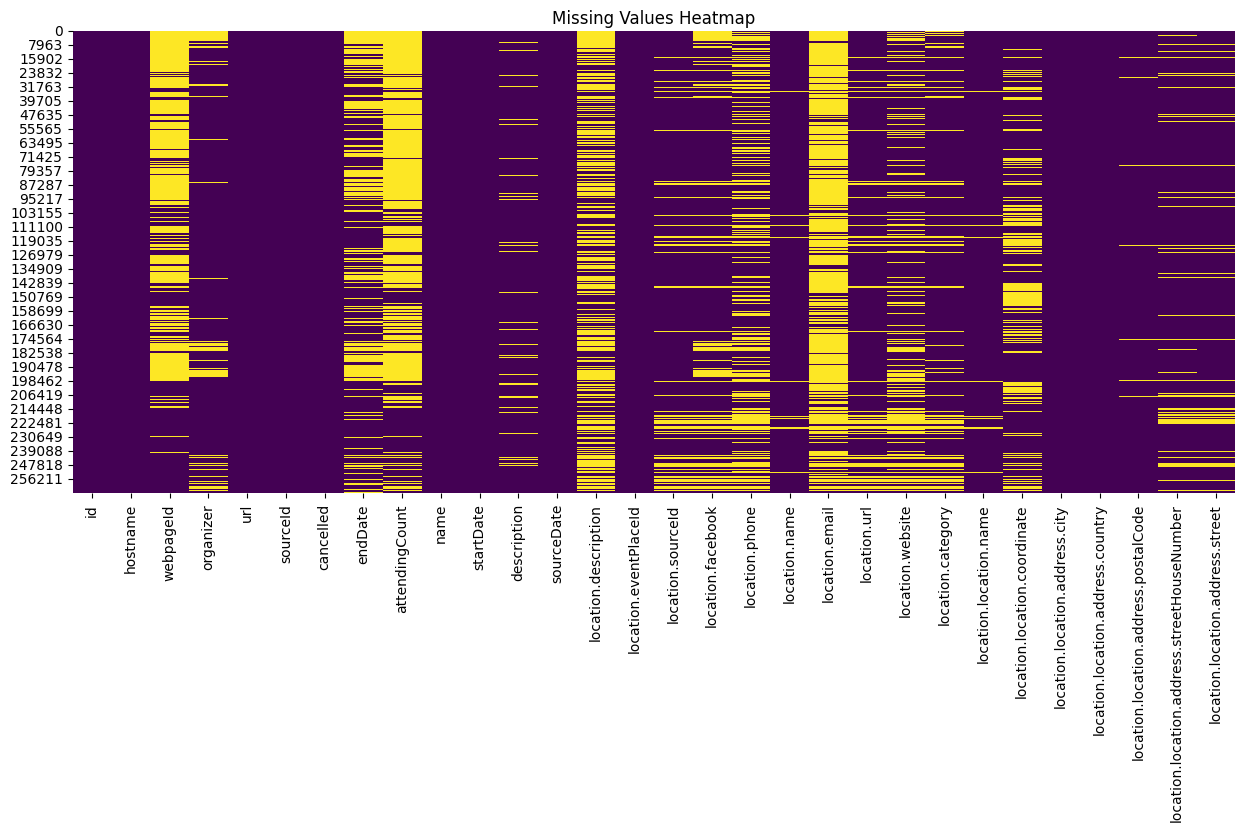

In [ ]:
# drop columns with more than 80% missing values
events_df = events_df.dropna(thresh=events_df.shape[0]*0.2, axis=1)
logging.info('Shape of the DataFrame after dropping columns with more than 80% missing values: {}'.format(events_df.shape))
# again plot missing values after cleaning
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
sns.heatmap(events_df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

## Feature Engineering

### Create Feature "dayofweek" and only consider Wednesdays

In [ ]:
if 'startDate' in events_df.columns and events_df['startDate'].dtype != 'datetime64[ns]':
    events_df['startDate'] = pd.to_datetime(events_df['startDate'], format='mixed', utc=True)

# add column for day of week
events_df['dayofweek'] = events_df['startDate'].dt.dayofweek
# only consider events on Wednesdays
events_df = events_df[events_df['dayofweek'] == 2]
events_df.reset_index(drop=True, inplace=True)
# log the number of events remaining
logging.info('Number of events after filtering for Wednesdays: {}'.format(events_df.shape[0]))

INFO:root:Number of events after filtering for Wednesdays: 29549


### Continue with a sample of the data
### NOTE: When the whole dataset of Wednesdays should be used then comment out the following 3 lines

In [ ]:
# sample the data to reduce the number of events, e.g. only select 2000 events
# events_df = events_df.sample(n=2000, random_state=42)
# events_df.reset_index(drop=True, inplace=True)
# logging.info('Number of events after sampling: {}'.format(events_df.shape[0]))

INFO:root:Number of events after sampling: 2000


## Derive further time features from the startDate column

In [ ]:
# Create year column
events_df['year'] = events_df['startDate'].dt.year
# Create month column
events_df['month'] = events_df['startDate'].dt.month
# Create column with startHour
events_df['starting_hour'] = events_df['startDate'].apply(lambda x: x.hour)

## Extract the season from startDate

In [ ]:
# create a function to determine the season
def get_season(date: pd.Timestamp) -> str:
    """
    returns the season of a given date
    :param date: date for which the season should be determined
    :return: season of the given date
    """
    # spring
    if date.month >= 3 and date.month <= 5:
        return 'spring'
    # summer
    elif date.month >= 6 and date.month <= 8:
        return 'summer'
    # autumn
    elif date.month >= 9 and date.month <= 11:
        return 'autumn'
    # winter
    else:
        return 'winter'

# apply the function to the startDate column
events_df['season'] = events_df['startDate'].apply(get_season)

## Derive time_of_day from starting_hour. That's a second derivate feature 😄

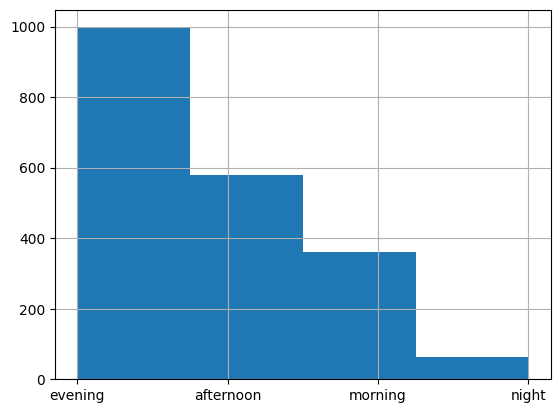

In [ ]:
# create a column that classifies the events into morning, afternoon and evening
def get_time_of_day(time: int) -> str:
    """
    returns the time of day of a given start time
    :param time: time for which the time of day should be determined
    :return: time of day of the given time
    """
    # morning
    if time >= 6 and time < 12:
        return 'morning'
    # afternoon
    elif time >= 12 and time < 18:
        return 'afternoon'
    # evening
    elif time >= 18 and time < 24:
        return 'evening'
    # night
    else:
        return 'night'
    
# apply the function to the starting_hour column
events_df['time_of_day'] = events_df['starting_hour'].apply(get_time_of_day)
# plot time_of_day
events_df['time_of_day'].hist(bins=4)
plt.show()

## Map zip codes to district names

In [ ]:
# instead of having to choose location based on postcal code, it would be way nicer to choose location based on district
# therefore we need to add a column containing the district of the event
# we can get the district by using a mapping from postcal code to district
# https://home.meinestadt.de/stuttgart/postleitzahlen

zip_code_to_district = {
    "70173": "Europaviertel",
    "70174": "Relenberg",
    "70178": "Karlshöhe",
    "70191": "Am Rosensteinpark",
    "70193": "Kräherwald",
    "70195": "Botnang-West",
    "70197": "Vogelsang",
    "70199": "Südheim",
    "70372": "Bad Cannstatt",
    "70567": "Sternhäule",
    "70569": "Pfaffenwald",
    "70437": "Freiberg",
    "70176": "Rosenberg",
    "70188": "Uhlandshöhe",
    "70374": "Im Geiger",
    "70439": "Zuffenhausen-Elbelen",
    "70190": "Stöckach",
    "70180": "Weinsteige",
    "70182": "Heusteigviertel",
    "70376": "Neckarvorstadt",
    "70378": "Mönchfeld",
    "70597": "Waldau",
    "70565": "Möhringen-Süd",
    "70469": "Feuerbach-Ost",
    "70199": "Südheim"
}


def get_district_from_postcal_code(postcalCode: int):
    """
    returns the district of a given postal code
    :param postcalCode: postal code for which the district should be determined
    :return: district of the given postal code
    """
    try:
        district = zip_code_to_district[str(postcalCode)]
    except KeyError:
        district = "Other"
    return district
    
# apply the function to the postal code column
events_df['district'] = events_df['location.location.address.postalCode'].apply(get_district_from_postcal_code)

## Create features supercategory and subcategory

In [ ]:
# split entry in eventData.location.category by / 
def extract_categories(df: pd.DataFrame):
    """
    extracts the supercategory and subcategory from the eventData.location.category column
    :param df: dataframe containing the events
    :return: dataframe containing the events with two new columns supercategory and subcategory
    """
    events_df['supercategory'] = np.where(events_df['location.category'].notnull(), events_df['location.category'].str.split('/').str[0], 'anderes')
    events_df['subcategory'] = np.where(events_df['location.category'].notnull(), events_df['location.category'].str.split('/').str[1], 'anderes')
    # everything to lowercase
    events_df['supercategory'] = events_df['supercategory'].str.lower()
    events_df['subcategory'] = events_df['subcategory'].str.lower()
    # if subcategory has no value, set it to "No Subcategory"
    events_df['subcategory'] = np.where(events_df['subcategory'].isnull(), 'no subcategory', events_df['subcategory'])
    return events_df

events_df = extract_categories(events_df)

## Save dataframe

In [ ]:
events_df.to_csv('2000_events_sample_notebook.csv', index=False)
logger.info('DataFrame saved to csv file.')

INFO:__main__:DataFrame saved to csv file.


# Adding a Flair to each event

## Imports for flair ingestion

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import pyLDAvis
import pyLDAvis.lda_model
import pandas as pd

## Define Stopwords

In [ ]:

# Download German language resources for NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Read DataFrame with event descriptions
df = pd.read_csv('2000_events_sample_notebook.csv')  # Replace 'your_dataframe.csv' with your actual file path or URL

# Get German stop words from NLTK
german_stop_words = set(stopwords.words('german'))
english_stop_words = set(stopwords.words('english'))
self_defined_stop_words = ['stuttgart', 'de', 'www', 'uhr', '00', '30', '19', '20', '21', '22', '23', '00', '10', '11', '12', '13', '14', '1', 'http', 'com', 'br', 'https']

combined_stop_words = german_stop_words.union(english_stop_words).union(self_defined_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/juliusdoebelt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/juliusdoebelt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Convert the event descriptions to a matrix of token counts 

In [ ]:
# Convert event descriptions to document-term matrix
vectorizer = CountVectorizer(stop_words=list(combined_stop_words), max_features=1000, max_df=0.85)

event_descriptions = []
for index, row in df.iterrows():
    event_description = row['description']
    if isinstance(event_description, str):
        event_descriptions.append(event_description)
    else:
        event_descriptions.append('Anderes')

X = vectorizer.fit_transform(event_descriptions)

## Apply Latent Dirichlet Allocation (LDA)

In [ ]:
num_topics = 5  # Adjust based on the desired number of categories
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
document_topics = lda.fit_transform(X)

# Get the most probable topic for each document (event)
predicted_labels = document_topics.argmax(axis=1)

## Visualize the topics

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, X, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3     -30.758141  15.610538       1        1  28.084493
0     -33.491142 -22.123487       2        1  27.490282
4      -5.615365  43.740391       3        1  21.117106
2      20.594652  14.688796       4        1  13.355672
1       5.505445 -19.837641       5        1   9.952448, topic_info=          Term        Freq       Total Category  logprob  loglift
221         dj  194.000000  194.000000  Default  30.0000  30.0000
515       kurs  119.000000  119.000000  Default  29.0000  29.0000
74   anmeldung  218.000000  218.000000  Default  28.0000  28.0000
46          ab  329.000000  329.000000  Default  27.0000  27.0000
553       live  170.000000  170.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
979       zeit   27.759075  142.317357   Topic5  -5.0687   0.6729
16          18   28.188833  225.429846   Topic5  -5.0533   0.2283
221         dj   26.017325  194.729490   Topic5  -5.1335   0.2945
354       geht   23.927335  186.017779   Topic5  -5.2172   0.2565
187       club   23.830976  109.617591   Topic5  -5.2212   0.7813

[330 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
3         2  0.300999            02
3         3  0.013087            02
3         4  0.680520            02
3         5  0.013087            02
4         2  0.368476            03
...     ...       ...           ...
994       5  0.109336          zwei
997       1  0.051248  öffentlichen
997       2  0.358734  öffentlichen
997       5  0.614972  öffentlichen
998       2  0.979267     überblick

[677 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 3, 2])

In [22]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

n_top_words = 20
tf_feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: freuen anmeldung mittwoch bitte veranstaltung ab findet fragen treffen gibt einfach 16 herzlich 18 unserer 15 17 statt zouk benz
Topic #1: ab stadtpalais film geschichte mittwoch eintritt bar museum ausstellung salsa mal facebook frei david lassen jahren floor neue minuten 18
Topic #2: kurs yoga 18 mittwoch ab 2020 gibt 2022 eur 0711 02 artists line 15 16 anmeldung mi 03 neue ly
Topic #3: mehr dr musik stuttgarter welt dabei menschen seit zwei immer wurde leben württemberg ganz macht baden neuen vortrag deutschland schon
Topic #4: dj live band album tour songs ab party club rock music mittwoch musik gibt us besten pop show mal event


## Assign labels for each topic

In [28]:


# Map the topic labels to your predefined categories
topic_labels_mapping = {
    0: 'Gesellig',
    1: 'Unterhaltsam',
    2: 'Körperbewusst',
    3: 'Künstlerisch',
    4: 'Energetisch'
}

# Map the predicted labels to category names
predicted_category_labels = [topic_labels_mapping[label] for label in predicted_labels]

# Add the predicted category labels to the DataFrame
df['stimmung'] = predicted_category_labels

## Check Output

In [29]:
# Print or further analyze the predicted category labels
print(df[['description', 'stimmung']])

                                            description       stimmung
0     ••• V O R F E I E R T A G •••\nMittwoch, 03. J...    Energetisch
1     Das galao Konzert wird stattfinden in der\nALI...    Energetisch
2     Eine Veranstaltung von RADIO CLASH ENTERTAINME...    Energetisch
3     GALA-PREVIEW "DOWTON ABBEY II  - EINE NEUE ÄRA...    Energetisch
4     Sanfte Atem- und Yogaübungen sowie die Tiefene...  Körperbewusst
...                                                 ...            ...
1995                                                NaN       Gesellig
1996  DINAH\nwww.listentodinah.com\nhttps://youtu.be...   Künstlerisch
1997  >>> Kostenloser Workshop: Visual FX - Getting ...       Gesellig
1998  JETZT NEUE TERMINE!\n\nNach der Arbeit direkt ...       Gesellig
1999  Yoga für einen gesunden Rücken sensibilisiert ...  Körperbewusst

[2000 rows x 2 columns]


## Save dataframe with Flair

In [30]:
df.to_csv('2000_events_sample_notebook.csv', index=False)